In [127]:
import os
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import torch.nn
from torch.utils.data import Dataset, DataLoader
import torch.optim
import torch.nn.functional as F

In [128]:
ROOT_DIR = "train_data/"
texts50 = ROOT_DIR + "50texts_tacred/"
cll3 = ROOT_DIR + "coll3_tacred/"
legal = ROOT_DIR + "legal/"
tacred2 = ROOT_DIR + "tacred2/"
tacred3 = ROOT_DIR + "tacred3/"

In [129]:
def create_dataframe(dir):
    df = pd.DataFrame(columns=["fName", "text", "entities"])
    df = df.set_index("fName")
    files = os.listdir(dir)
    for name in files:
        fname, ext = name.split(".")
        with open(dir + name) as f:
            text = f.read()
        if ext == "txt":
            ann_fname = files[files.index(fname + ".ann")]
            with open(dir + ann_fname) as f_ann:
                entities = f_ann.readlines()
            new_entities = []
            for i in range(len(entities)):
                entity_type = entities[i][0]
                entities[i] = entities[i][:-1]
                if entity_type == "T":
                    entities[i] = entities[i].split("\t")
                    entities[i] = entities[i][1:]
                    src = entities[i][1]
                    entities[i] = entities[i][0].split()
                    entities[i].append(src)
                    assert len(entities[i]) <= 5
                    if len(entities[i]) == 5:
                        begin = entities[i][1]
                        inter1, inter2 = entities[i][2].split(";")
                        end = entities[i][3]
                        new_entities.append(
                            [entities[i][0], begin, inter1, entities[i][4]]
                        )
                        new_entities.append(
                            [entities[i][0], inter2, end, entities[i][4]]
                        )
                    else:
                        new_entities.append(entities[i])
            df.loc[fname] = [text, new_entities]
    return df

In [130]:
df1 = create_dataframe(texts50)
df2 = create_dataframe(cll3)
df3 = create_dataframe(legal)
df4 = create_dataframe(tacred2)
df5 = create_dataframe(tacred3)

In [131]:
df1.shape[0] + df2.shape[0] + df3.shape[0] + df4.shape[0] + df5.shape[0]

841

In [132]:
total_df = pd.concat([df1, df2, df3, df4, df5])

In [133]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [134]:
# change the parameter of max tokens what model can process to get tokenization of the whole input
# (not only first 512 tokens, which BERT can process  by its architecture)
tokenizer = AutoTokenizer.from_pretrained(
    "yqelz/xml-roberta-large-ner-russian", model_max_length=int(1.5e4)
)

In [135]:
def identify_tokens(df_sample):
    sample_text = df_sample["text"]
    sample_en = df_sample["entities"]
    sample_text_tokenized = tokenizer.tokenize(sample_text)
    trash_symbols_count = []
    for i in range(len(sample_text)):
        cur = (
            1
            if (
                sample_text[i] == " "
                or sample_text[i] == "\n"
                or sample_text[i] == "\xa0"
            )
            else 0
        )
        if i == 0:
            trash_symbols_count.append(cur)
        else:
            trash_symbols_count.append(trash_symbols_count[-1] + cur)
    cur_entity_id = 0
    processed_symbols = 0
    mappings = []
    begin = int(sample_en[cur_entity_id][1])
    end = int(sample_en[cur_entity_id][2])
    assert end < len(trash_symbols_count)
    begin -= trash_symbols_count[begin]
    end -= trash_symbols_count[end]

    for token in sample_text_tokenized:
        while processed_symbols > end and (cur_entity_id + 1) < len(sample_en):
            cur_entity_id += 1
            begin = int(sample_en[cur_entity_id][1])
            end = int(sample_en[cur_entity_id][2]) - 1
            begin -= trash_symbols_count[begin]
            end -= trash_symbols_count[end]
        if begin <= processed_symbols <= end:
            first_token = not (
                len(mappings) != 0 and sample_en[cur_entity_id] == mappings[-1][1]
            )
            mappings.append((token, sample_en[cur_entity_id], first_token))
        else:
            mappings.append((token, False))
        subword_check = token[0] == "▁"
        processed_symbols = processed_symbols + len(token) - int(subword_check)

    for i in range(len(mappings)):
        if len(mappings[i]) == 2:
            mappings[i] = "O"
        else:
            if mappings[i][-1]:
                mappings[i] = "B-" + mappings[i][1][0]
            else:
                mappings[i] = "I-" + mappings[i][1][0]
    mappings.insert(0, 'O') # start token
    mappings.append('O') # end token
    return mappings

In [136]:
total_df["tokenized_text"] = total_df["text"].apply(tokenizer.tokenize)
total_df["tokenizer_output"] = total_df["text"].apply(
    lambda x: tokenizer(x, return_tensors="pt", padding=True, truncation=True)
)
#add start and end tokens to map tokenizer output
total_df['tokenized_text'] = total_df['tokenized_text'].apply(lambda x: ['START'] + x + ['END'])
total_df["classified_tokens"] = total_df.apply(identify_tokens, axis=1)

In [137]:
total_df.reset_index(inplace=True)
total_df.head()

,fName,text,entities,tokenized_text,tokenizer_output,classified_tokens
0,104189_text,Полиция Бельгии арестовала двух человек по под...,"[[ORGANIZATION, 0, 15, Полиция Бельгии], [COUN...","[START, ▁Поли, ция, ▁Бель, ги, и, ▁арест, овал...","[input_ids, attention_mask]","[O, B-ORGANIZATION, I-ORGANIZATION, I-ORGANIZA..."
1,119336_text,"Семья Обамы приобрела дом в Вашингтоне за 8,1 ...","[[PERSON, 6, 11, Обамы], [CITY, 28, 38, Вашинг...","[START, ▁Сем, ья, ▁Оба, мы, ▁приобрел, а, ▁дом...","[input_ids, attention_mask]","[O, O, O, B-PERSON, I-PERSON, O, O, O, O, B-CI..."
2,11766_text,Скончался бывший премьер-министр России Виктор...,"[[PROFESSION, 17, 32, премьер-министр], [COUNT...","[START, ▁С, кон, ча, лся, ▁бы, вший, ▁премьер,...","[input_ids, attention_mask]","[O, O, O, O, O, O, O, B-PROFESSION, I-PROFESSI..."
3,11899_text,Странное преступление против семьи россиян в А...,"[[NATIONALITY, 35, 42, россиян], [COUNTRY, 45,...","[START, ▁Стран, ное, ▁пре, ступление, ▁против,...","[input_ids, attention_mask]","[O, O, O, O, O, O, O, B-NATIONALITY, O, B-COUN..."
4,120890_text,Важные перемены в жизни рэпера Jay Z: Он помен...,"[[PERSON, 31, 36, Jay Z], [PERSON, 62, 67, JAY...","[START, ▁В, аж, ные, ▁перемен, ы, ▁в, ▁жизни, ...","[input_ids, attention_mask]","[O, O, O, O, O, O, O, O, O, O, B-PERSON, I-PER..."


<AxesSubplot:>

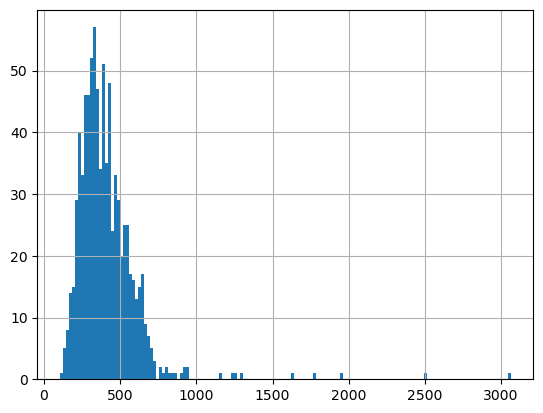

In [138]:
total_df["tokenized_text"].apply(len).hist(bins=150)

In [139]:
lens = total_df["classified_tokens"].apply(len)
print(
    f"Number of samples in train dataset, which have more tokens, when BERT can process - {lens[lens > 512].count() / lens.count() * 100:.3f}%"
)

Number of samples in train dataset, which have more tokens, when BERT can process - 21.284%


Dataset have 21% of samples, what can't be processed by BERT(For example, in document '1109' input text tokenized at more than 3000 tokens). To deal with this problem, we will use sliding window approach. We will split each sample into several samples, each of which will contain 512 tokens. We will use 256 tokens overlap between samples.

In [140]:
total_df["input_ids"] = total_df["tokenizer_output"].apply(lambda x: x["input_ids"])
total_df["attention_mask"] = total_df["tokenizer_output"].apply(
    lambda x: x["attention_mask"]
)

In [141]:
sample = total_df[total_df["fName"] == "1109"]
iids = sample["input_ids"].values[0]
attn = sample["attention_mask"].values[0]

In [142]:
iids.shape, attn.shape, len(sample["tokenized_text"].values[0])

(torch.Size([1, 3065]), torch.Size([1, 3065]), 3065)

In [143]:
# drop useless columns
total_df.drop(["entities", "text", 'tokenizer_output'], axis=1, inplace=True)

In [144]:
# split samples with more than 512 tokens
def split_sample(sample):
    tokenized_text = sample["tokenized_text"]
    classified_entities = sample["classified_tokens"]
    fname = sample["fName"]
    input_ids = sample["input_ids"]
    attention_mask = sample["attention_mask"]
    if input_ids.shape[1] <= 512:
        return pd.DataFrame(
            [[fname, input_ids, attention_mask, tokenized_text, classified_entities]],
            columns=[
                "fName",
                "input_ids",
                "attention_mask",
                "tokenized_text",
                "classified_tokens",
            ],
        )
    else:
        samples = []
        for i in range(0, len(tokenized_text), 256):
            if i + 512 <= len(tokenized_text):
                samples.append(
                    [
                        fname,
                        input_ids[:, i : i + 512],
                        attention_mask[:, i : i + 512],
                        tokenized_text[i : i + 512],
                        classified_entities[i : i + 512],
                    ]
                )
            else:
                samples.append(
                    [
                        fname,
                        input_ids[:, -512:],
                        attention_mask[:, -512:],
                        tokenized_text[-512:],
                        classified_entities[-512:],
                    ]
                )
        return pd.DataFrame(
            samples, columns=["fName", "input_ids", "attention_mask", "tokenized_text", "classified_tokens"]
        )

In [145]:
total_df

,fName,tokenized_text,classified_tokens,input_ids,attention_mask
0,104189_text,"[START, ▁Поли, ция, ▁Бель, ги, и, ▁арест, овал...","[O, B-ORGANIZATION, I-ORGANIZATION, I-ORGANIZA...","[[tensor(0), tensor(58083), tensor(8007), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,119336_text,"[START, ▁Сем, ья, ▁Оба, мы, ▁приобрел, а, ▁дом...","[O, O, O, B-PERSON, I-PERSON, O, O, O, O, B-CI...","[[tensor(0), tensor(120400), tensor(17471), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,11766_text,"[START, ▁С, кон, ча, лся, ▁бы, вший, ▁премьер,...","[O, O, O, O, O, O, O, B-PROFESSION, I-PROFESSI...","[[tensor(0), tensor(589), tensor(6173), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,11899_text,"[START, ▁Стран, ное, ▁пре, ступление, ▁против,...","[O, O, O, O, O, O, O, B-NATIONALITY, O, B-COUN...","[[tensor(0), tensor(107722), tensor(5509), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,120890_text,"[START, ▁В, аж, ные, ▁перемен, ы, ▁в, ▁жизни, ...","[O, O, O, O, O, O, O, O, O, O, B-PERSON, I-PER...","[[tensor(0), tensor(417), tensor(11153), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...,...
836,15895_text,"[START, ▁Стив, а, ▁Джо, б, са, ▁похорон, ят, ▁...","[O, B-PERSON, I-PERSON, I-PERSON, I-PERSON, I-...","[[tensor(0), tensor(177256), tensor(59), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
837,139972_text,"[START, ▁Витамин, ▁Б, ▁для, ▁Сочи, ▁от, ▁худож...","[O, O, O, O, B-CITY, O, B-PROFESSION, I-PROFES...","[[tensor(0), tensor(230512), tensor(1537), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
838,28585_text,"[START, ▁Никола, с, ▁Ма, ду, ро, ▁стал, ▁прези...","[O, B-PERSON, I-PERSON, I-PERSON, I-PERSON, I-...","[[tensor(0), tensor(34785), tensor(650), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
839,127332_text,"[START, ▁Фи, гур, ист, ка, ▁Ю, лия, ▁Лип, ни, ...","[O, O, O, O, O, B-PERSON, I-PERSON, I-PERSON, ...","[[tensor(0), tensor(58037), tensor(20522), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [146]:
total_df = total_df.apply(split_sample, axis=1)

In [147]:
total_df = pd.concat(total_df.values)
total_df.reset_index(inplace=True)
total_df.drop("index", axis=1, inplace=True)

<AxesSubplot:>

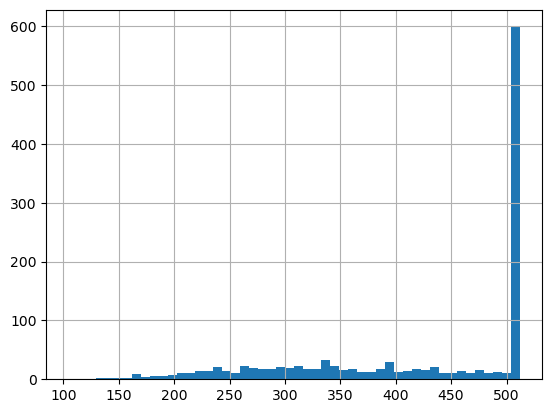

In [148]:
total_df["tokenized_text"].apply(len).hist(bins=50)

In [149]:
# test token mapping for the sample
n = 3
sample = total_df.iloc[n]
sample_tokens = sample["tokenized_text"]
sample_entities = sample["classified_tokens"]
a = np.array([sample_tokens, sample_entities])
a.T

array([['START', 'O'],
       ['▁Стран', 'O'],
       ['ное', 'O'],
       ...,
       ['▁во', 'O'],
       ['▁время', 'O'],
       ['▁интервью', 'O']], dtype='<U19')

In [150]:
unique_entities = []
for sample in total_df["classified_tokens"]:
    for token in sample:
        unique_entities.append(token)
unique_entities = np.unique(unique_entities)

In [151]:
id2label = {}
label2id = {}

for i in range(len(unique_entities)):
    id2label[i] = unique_entities[i]
    label2id[unique_entities[i]] = i

In [152]:
labels_num = len(unique_entities)

In [153]:
labels_num

59

In [155]:
class BertTokenClassification(torch.nn.Module):
    def __init__(self):
        super(BertTokenClassification, self).__init__()
        self.bert = AutoModelForTokenClassification.from_pretrained("yqelz/xml-roberta-large-ner-russian")
        self.bert.config.id2label = id2label
        self.bert.config.label2id = label2id
        self.bert.classifier = torch.nn.Linear(1024, labels_num)

    def forward(self, input_id, mask, label):
        output = self.bert(
            input_ids=input_id, attention_mask=mask, labels=label, return_dict=False
        )
        return output

In [156]:
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    @staticmethod
    def df_sample_to_tensor(row):
        data = (row['input_ids'], row['attention_mask'])
        labels = row['classified_entities']
        return data, labels

    def __getitem__(self, idx):
        return self.df_sample_to_tensor(self.df.iloc[idx])

In [157]:
def tokenization_complement(tensor):
    complement_size = 512 - tensor.shape[1]
    zeros_complement = torch.zeros((1,complement_size))
    new_sample = torch.cat((tensor, zeros_complement,), dim=1)
    assert new_sample.shape[1] == 512
    return new_sample

In [ ]:
total_df['input_ids'] = total_df['input_ids'].apply(tokenization_complement)
total_df['attention_mask'] = total_df['attention_mask'].apply(tokenization_complement)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(total_df, train_size=0.9)

In [ ]:
from tqdm import tqdm

BATCH_SIZE = 4
lr = 3e-4
EPOCH_NUMBER = 3

def train_loop(model, train_d, val_d, epoch_num=EPOCH_NUMBER):
    train_dataset = TextDataset(train_d)
    val_dataset = TextDataset(val_d)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epoch_num):
        acc_train = 0
        cur_loss_train = 0

        model.train()
        for data, labels in tqdm(train_dataloader):
            data = data.to(device)
            labels = torch.tensor(labels).to(device)
            print(data.shape)
            print(labels.shape)

            # optimizer.zero_grad()
            #
            # loss, logits = model(*data)
            # for i in range(logits.shape[0]):
            #     predictions = logits.argmax(dim=1)



In [ ]:
model = BertTokenClassification().to(device)

In [ ]:
#TODO tokenizer produce 2 additional tokens start, end
#TODO complement labels list for dataset
#TODO ???

In [ ]:
train_loop(model, train_data, val_data)

In [ ]:
# sample = 'my name is nikita'
# sample_tokens = tokenizer(sample, return_tensors="pt", padding=True, truncation=True)
#
# with torch.no_grad():
#     logits = model(**sample_tokens).logits
#
# predicted_token_class_ids = logits.argmax(axis=2)
# predicted_tokens_classes = [model.config.id2label[t.item()] for t in predicted_token_class_ids[0]]
# token_words = tokenizer.convert_ids_to_tokens(sample_tokens['input_ids'][0])
# print(predicted_tokens_classes)